### This project is built to show image quality improvement using pythn

## 1. Importing packages

In [1]:
%cd drive/MyDrive/ColabNotebooks/ImageProcesing/SuperResolution/

/content/drive/MyDrive/ColabNotebooks/ImageProcesing/SuperResolution


In [2]:
%pwd

'/content/drive/MyDrive/ColabNotebooks/ImageProcesing/SuperResolution'

In [3]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Keras: 2.6.0
OpenCV: 4.1.2
NumPy: 1.19.5
Matplotlib: 3.2.2
Scikit-Image: 0.16.2


In [4]:
# import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [5]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


In [6]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height =int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('fimages/{}'.format(file), img)

In [7]:
prepare_images('images/',2)

Saving baby_GT.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving head_GT.bmp
Saving woman_GT.bmp
Saving baboon.bmp
Saving barbara.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving zebra.bmp


In [8]:
# test the generated images using the image quality metrics

for file in os.listdir('fimages/'):
    
    # open target and reference images
    target = cv2.imread('fimages/{}'.format(file))
    ref = cv2.imread('images/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


baby_GT.bmp
PSNR: 34.371806409661986
MSE: 71.28874588012695
SSIM: 0.9356987872724932

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

woman_GT.bmp
PSNR: 29.326236280817465
MSE: 227.812729498164
SSIM: 0.9335397280466592

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883

In [13]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(learning_rate=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [14]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [15]:
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('images/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 22.285122135474143
MSE: 1152.628628072958
SSIM: 0.6327198184502538

Reconstructed Image: 
PSNR: 23.03562694737879
MSE: 969.7034055863953
SSIM: 0.7090934397381169



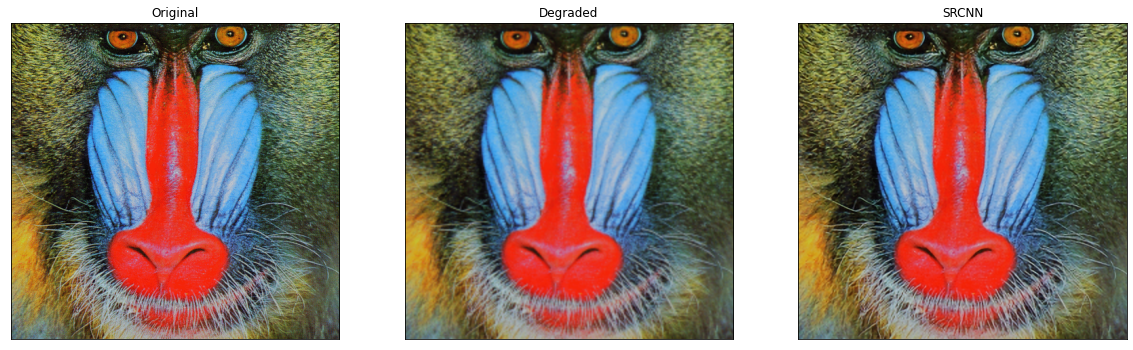

In [18]:
ref, degraded, output, scores = predict('fimages/baboon.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [19]:
for file in os.listdir('fimages'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('fimages/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Saving baby_GT.bmp
Saving bird_GT.bmp
Saving head_GT.bmp
Saving butterfly_GT.bmp
Saving woman_GT.bmp
Saving baboon.bmp
Saving comic.bmp
Saving barbara.bmp
Saving coastguard.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving zebra.bmp
